# Multi-class Classification
This notebook contains the code to experiment with the embeddings created by a fine-tuned S-BERT model for **multi-class classification**. Includes loading data, loading the model, and running different models for the classification

In [ ]:
! pip install \
  scprep\
  sentence_transformers==0.4.0 \
  phate==1.0.4

For development work, in case you want to update the files in your GitHub branch by rerunning the clone, you first have to empty the folder.

In [ ]:
!rm -rf policy-data-analyzer/

In [ ]:
# Define branch to clone
! branch_name='master' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 642, done.
remote: Counting objects: 100% (642/642), done.
remote: Compressing objects: 100% (481/481), done.
remote: Total 3561 (delta 308), reused 486 (delta 161), pack-reused 2919
Receiving objects: 100% (3561/3561), 167.76 MiB | 24.68 MiB/s, done.
Resolving deltas: 100% (1855/1855), done.
Checking out files: 100% (853/853), done.


In [3]:
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
import time
import cupy as cp
import json

from data_loading.src.utils import *
#from model_evaluation.src.model_evaluator import *
#from data_visualization.src.plotting import *
from data_augmentation.src.zero_shot_classification.latent_embeddings_classifier import *


## Run multi class classification experiments

### Data Loading

In [4]:
data_path = "C:\\Users\\allie\\Documents\\GitHub\\policy-data-analyzer\\tasks\\text_preprocessing\\output\\reduced\\"
experiment="Pre_tagged_0.5_"

with open(data_path+experiment+"sentences.json", "r", encoding="utf-8") as f:
        sentences = json.load(f)
with open(data_path+experiment+"labels.json", "r", encoding="utf-8") as f:
    labels = json.load(f)
train_sents, test_sents, train_labels, test_labels = train_test_split(sentences,labels, test_size=0.2)

label_names = unique_labels(train_labels)
print("Label names:", label_names)
print("Train Sentence:", train_sents[2], "\nTrain Label:", train_labels[2])
print("Test Sentence:", test_sents[2], "\nTest Label:", test_labels[2])

Label names: ['Tax deduction', 'Technical assistance', 'Credit', 'Guarantee', 'Direct payment', 'Supplies', 'Fine']
Train Sentence: El juez debe disponer que el solicitante cumpla con la adecuacion de la contracautelaofrecidag) En aquellos casos en los que se someta a revision del organo judicial competente la legalidad yel cumplimiento de las normas previstas para el inicio y tramite del procedimiento de ejecucioncoactiva mediante demanda de revision judicial regulada en la Ley 26979, Ley de Procedimiento deEjecucion Coactiva, la ejecucion coactiva solo es suspendida si el cumplimiento de la obligacion esgarantizado mediante contracautela, la que debe cumplir con iguales requisitos a los senalados enlos incisos precedentes. 
Train Label: Guarantee
Test Sentence: Avisos obligatorios en las areas forestales. 
Test Label: Direct payment


### Load best model from training

In [6]:
model_name = "paraphrase-xlm-r-multilingual-v1"
test_perc = 0.20
num_epochs = 2
model_deets = f"model={model_name}_test-perc={test_perc}_n-epoch={num_epochs}"

#saved_model_path = f"{base_path}/Modeling/{classifier}ClassificationExperiments/TESTS/{experiment}"

In [7]:
#saved_model = SentenceTransformer(saved_model_path)
# no saved model task so
saved_model = SentenceTransformer(model_name)

c:\Users\allie\Documents\GitHub\policy-data-analyzer\vvenv\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
# Simple embeddings, no projection matrix added
train_sent_embs = encode_all_sents(train_sents, saved_model)
test_sent_embs = encode_all_sents(test_sents, saved_model)

100%|██████████| 1520/1520 [00:23<00:00, 65.87it/s]


### Test multiple classifiers
- Random Forests

In [9]:
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=69420)
clf.fit(np.vstack(train_sent_embs), train_labels)
clf_preds = [clf.predict(sent_emb)[0] for sent_emb in test_sent_embs]
print(classification_report(test_labels, clf_preds))

                      precision    recall  f1-score   support

              Credit       0.00      0.00      0.00        53
      Direct payment       0.77      0.74      0.75       324
                Fine       0.00      0.00      0.00        93
           Guarantee       0.00      0.00      0.00       107
            Supplies       0.00      0.00      0.00        53
       Tax deduction       0.57      0.68      0.62       420
Technical assistance       0.60      0.91      0.73       470

            accuracy                           0.63      1520
           macro avg       0.28      0.33      0.30      1520
        weighted avg       0.51      0.63      0.56      1520



c:\Users\allie\Documents\GitHub\policy-data-analyzer\vvenv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\allie\Documents\GitHub\policy-data-analyzer\vvenv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\allie\Documents\GitHub\policy-data-analyzer\vvenv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/MulticlassClassificationExperiments/TESTS/EXP17/RandomForest_cm.png


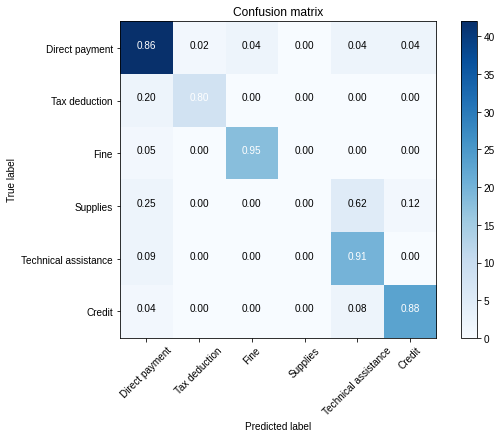

In [ ]:
numeric_preds = labels2numeric(clf_preds, label_names)
numeric_test_labels = labels2numeric(test_labels, label_names)
evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)
evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{saved_model_path}/RandomForest")

- Support Vector Machines

In [ ]:
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(np.vstack(train_sent_embs), train_labels)
clf_preds = [clf.predict(sent_emb)[0] for sent_emb in test_sent_embs]
print(classification_report(test_labels, clf_preds))

                      precision    recall  f1-score   support

              Credit       0.89      0.92      0.91        26
      Direct payment       0.89      0.82      0.85        49
                Fine       0.86      0.95      0.90        19
            Supplies       1.00      0.50      0.67         8
       Tax deduction       0.91      1.00      0.95        10
Technical assistance       0.81      0.95      0.88        22

            accuracy                           0.87       134
           macro avg       0.89      0.86      0.86       134
        weighted avg       0.88      0.87      0.87       134



Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/MulticlassClassificationExperiments/TESTS/EXP17/SVM_cm.png


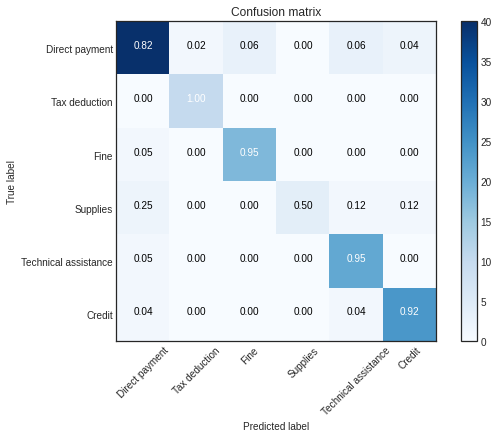

In [ ]:
numeric_preds = labels2numeric(clf_preds, label_names)
numeric_test_labels = labels2numeric(test_labels, label_names)
evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)
evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{saved_model_path}/SVM")

- Gradient Boosting trees

In [ ]:
!pip install xgboost \
  catboost

In [11]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier,
                              GradientBoostingClassifier)

In [12]:
cb = CatBoostClassifier(n_estimators=2000,
                        colsample_bylevel=0.06,
                        max_leaves=31,
                        subsample=0.67,
                        verbose=0,
                        thread_count=6,
                        random_state=69420,
                        bootstrap_type='Poisson')

gbm = GradientBoostingClassifier(n_estimators=2000,
                                 subsample=0.67,
                                 max_features=0.06,
                                 validation_fraction=0.1,
                                 n_iter_no_change=15,
                                 verbose=0,
                                 random_state=69420)

lgbm = LGBMClassifier(n_estimators=2000,
                      feature_fraction=0.06,
                      bagging_fraction=0.67,
                      bagging_freq=1,
                      verbose=0,
                      n_jobs=6,
                      random_state=69420)

xgb = XGBClassifier(n_estimators=2000,
                    tree_method='hist',
                    subsample=0.67,
                    colsample_level=0.06,
                    verbose=0,
                    n_jobs=6,
                    random_state=69420)

base_estim = DecisionTreeClassifier(max_depth=1, max_features=0.06)                          
ab = AdaBoostClassifier(base_estimator=base_estim,
                        n_estimators=500,
                        learning_rate=0.5,
                        random_state=69420)


In [15]:
gb_classifiers = [lgbm, gbm, xgb, ab] #cb
gb_names = [i.__class__.__name__ for i in gb_classifiers]

for clf, clf_name in zip(gb_classifiers, gb_names):
  print("Evaluating:", clf_name)
  print("Training...")
  clf.fit(np.vstack(train_sent_embs), train_labels)
  print("Predicting...")
  clf_preds = [clf.predict(sent_emb)[0] for sent_emb in test_sent_embs]
  print(classification_report(test_labels, clf_preds))
  #numeric_preds = labels2numeric(clf_preds, label_names)
  #numeric_test_labels = labels2numeric(test_labels, label_names)
  
  #evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)
  #evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{saved_model_path}/{clf_name}")
'''
Evaluating LGBMClassifier
                      precision    recall  f1-score   support

              Credit       0.75      0.28      0.41        53
      Direct payment       0.80      0.85      0.83       324
                Fine       0.74      0.69      0.71        93
           Guarantee       0.66      0.50      0.57       107
            Supplies       0.47      0.15      0.23        53
       Tax deduction       0.73      0.80      0.77       420
Technical assistance       0.84      0.90      0.87       470

            accuracy                           0.78      1520
           macro avg       0.71      0.60      0.63      1520
        weighted avg       0.77      0.78      0.76      1520

Evaluating: GradientBoostingClassifier
Training...
Predicting...
                      precision    recall  f1-score   support

              Credit       0.60      0.23      0.33        53
      Direct payment       0.79      0.79      0.79       324
                Fine       0.73      0.60      0.66        93
           Guarantee       0.59      0.44      0.50       107
            Supplies       0.29      0.15      0.20        53
       Tax deduction       0.70      0.80      0.74       420
Technical assistance       0.81      0.88      0.84       470

            accuracy                           0.74      1520
           macro avg       0.64      0.56      0.58      1520
        weighted avg       0.73      0.74      0.73      1520

Evaluating: XGBClassifier
'''

Evaluating: LGBMClassifier
Training...
[LightGBM] [Warning] feature_fraction is set=0.06, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06
[LightGBM] [Warning] bagging_fraction is set=0.67, subsample=1.0 will be ignored. Current value: bagging_fraction=0.67
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.06, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06
[LightGBM] [Warning] bagging_fraction is set=0.67, subsample=1.0 will be ignored. Current value: bagging_fraction=0.67
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

c:\Users\allie\Documents\GitHub\policy-data-analyzer\vvenv\lib\site-packages\xgboost\sklearn.py:1469: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or not (classes == expected_classes).all()


AttributeError: 'bool' object has no attribute 'all'